In [ ]:
import pandas as pd
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np
import tensorflow as tf 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [25]:
data = pd.read_csv('135L0587_139834200_pass.csv')
data = data[['t_off [us]','E_off [mJ]','v_peak_off [V]','avg_di/dt_off [kA/us]','avg_dv/dt_off [kV/us]','t_on [us]','E_on [mJ]','i_peak_on [A]','avg_di/dt_on [kA/us]','avg_dv/dt_on [kV/us]']]
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   t_off [us]             728 non-null    float64
 1   E_off [mJ]             728 non-null    float64
 2   v_peak_off [V]         728 non-null    float64
 3   avg_di/dt_off [kA/us]  728 non-null    float64
 4   avg_dv/dt_off [kV/us]  728 non-null    float64
 5   t_on [us]              728 non-null    float64
 6   E_on [mJ]              728 non-null    float64
 7   i_peak_on [A]          728 non-null    float64
 8   avg_di/dt_on [kA/us]   728 non-null    float64
 9   avg_dv/dt_on [kV/us]   728 non-null    float64
dtypes: float64(10)
memory usage: 57.0 KB


In [26]:
data.head()

,t_off [us],E_off [mJ],v_peak_off [V],avg_di/dt_off [kA/us],avg_dv/dt_off [kV/us],t_on [us],E_on [mJ],i_peak_on [A],avg_di/dt_on [kA/us],avg_dv/dt_on [kV/us]
0,0.898,162.482768,698.8000,-6.281048,2.429225,0.438,6.360069,1853.100000,8.743648,-2.211688
1,0.890,159.765714,695.4000,-6.233871,2.428169,0.436,6.331655,1849.200000,8.781762,-2.199675
2,0.884,157.678569,694.7925,-6.321511,2.479767,0.436,6.541971,1866.192593,8.920937,-2.215757
3,0.884,160.198292,699.0000,-6.101447,2.468841,0.436,6.339535,1870.800000,8.772541,-2.227273
4,0.888,159.374572,689.4000,-6.340761,2.427817,0.442,7.210611,1860.300000,9.017500,-2.143125


In [3]:

x_train = data.astype('float32') / 1.
x_train = x_train.values.reshape(x_train.shape + (1,))
x_train.shape

(728, 10, 1)

In [27]:
feature_shape = (10,1) # Depends on how many features we want to use, in this case 10: V_peak, Energy, Gradient etc.
batch_size = 128
latent_dim = 10  # Dimensionality of the latent space: can be defined manuelly

input_fea = keras.Input(shape=feature_shape)

x = layers.Conv1D(32, 3, padding='same', activation='relu')(input_fea)
x = layers.Conv1D(64, 3, padding='same', activation='relu',strides=(2))(x)
x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

# mapping inputs to our latent distribution parameters z_mean and z_log_var
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)


In [28]:
class Sampling(layers.Layer):
    def call(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.shape(z_mean)[1] #latent_dim
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.)
        
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
# add a layer sampling to the encoder model  
z = Sampling()([z_mean, z_log_var])

**Build an encoder model:**

In [29]:
encoder = keras.Model(input_fea, [z_mean, z_log_var, z], name="encoder")

#print summary
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 10, 32)       128         input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 5, 64)        6208        conv1d_5[0][0]                   
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 5, 64)        12352       conv1d_6[0][0]                   
____________________________________________________________________________________________

**Build a decoder model:**

In [30]:
# This is the input where we will feed `z`.
print("Latent vector shape", K.int_shape(z)[1:])
print(K.int_shape(z)) # z sampling's dimension
decoder_input = layers.Input(K.int_shape(z)[1:])
print(shape_before_flattening) # shape_before_flattening[1:] erased none
print(np.prod(shape_before_flattening[1:])) #except none
print()
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv1DTranspose(32, 3, padding='same', activation='relu', strides=(2))(x)
x = layers.Conv1D(1, 3,padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x, name='Decoder')
z_decoded = decoder(z)
decoder.summary()

Latent vector shape (10,)
(None, 10)
(None, 5, 64)
320

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 320)               3520      
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 64)             0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 10, 32)            6176      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 10, 1)             97        
Total params: 9,793
Trainable params: 9,793
Non-trainable params: 0
_________________________________________________________________


**Create a VAE class model**


In [31]:
# for using GradientTape, reduce_mean, reduce_sum
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        # reconstruction loss
        # the decoded samples should match the initial input images
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        # regularization loss
        # to learn well-formed latent spaces and reduce overfitting
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
        # regularization + reconstruction
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # Overwrite the train_setp method, to redefine what the fit funtion does.
        # this is needed to dealk with custom loss functions
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            z_decoded = self.decoder(z)
            
            # calculate losses
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, z_decoded), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            # sum losses
            total_loss = reconstruction_loss + kl_loss
            
        # Calculate the gradient and update the weights (Backward pass)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # update loss metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

**Create a VAE model instance and pass `encoder` and `decoder`.**

In [32]:
# Instantiate a VAE object
vae = VAE(encoder, decoder)

# Configure it
vae.compile(optimizer='rmsprop', loss=None)

### T-SNE Visualization

use **T-SNE** for visualiazation of reduced dimensionality.
Here we reduce from 10 dimensional latent space to 2-D.

In [37]:
encoder = Model(input_fea, z_mean)
encoded_input = encoder.predict(x_train)
latent_space = TSNE(n_components=2).fit_transform(encoded_input)

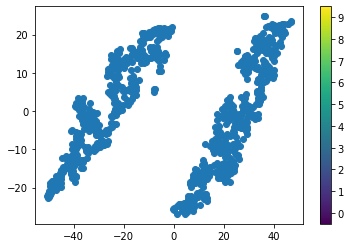

In [38]:
tsne_x = latent_space[:,0]
tsne_y = latent_space[:,1]
plt.scatter(tsne_x, tsne_y, cmap=plt.cm.get_cmap("jet"))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()